# DE with spline model

## Load the data

In [1]:
library(edgeR)
library(ggplot2)
library(splines)

Loading required package: limma



In [2]:
expression <- read.csv('data/human_specific_genes/expression.csv', header=TRUE, row.names=1)
head(expression)

,human_759_L1,human_j12_L1,human_j3_L1,human_j4_L1,human_j6_L1,human_759_L2,human_j12_L2,human_j3_L2,human_j4_L2,human_j6_L2,⋯,macaque_0704_L5,macaque_nb0904_L5,macaque_0701_L6,macaque_0703_L6,macaque_0704_L6,macaque_nb0904_L6,macaque_0701_WM,macaque_0703_WM,macaque_0704_WM,macaque_nb0904_WM
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DUSP18,0.008,0.03927492,0.06363636,0.02100840,0.01492537,0.017241379,0.12571429,0.18367347,0.02564103,0.09174312,⋯,0.259259259,0.044571429,0.167883212,0.200381679,0.214983713,0.032951289,0.07407407,0.085714286,0.10389610,0.01136364
ANGPTL4,0.008,0.17522659,0.01818182,0.04201681,0.05223881,0.004926108,0.34857143,0.05102041,0.02991453,0.08256881,⋯,0.015250545,0.012571429,0.102189781,0.091603053,0.052117264,0.021489971,0.16049383,0.057142857,0.03896104,0.02272727
NUP133,0.088,0.09969789,0.32727273,0.18487395,0.05970149,0.169950739,0.34285714,0.82653061,0.45299145,0.24770642,⋯,0.394335512,0.118857143,0.200729927,0.286259542,0.257328990,0.101719198,0.12345679,0.190476190,0.15584416,0.03409091
FRY,0.220,0.32930514,0.54545455,0.60084034,0.21641791,0.662561576,1.70285714,2.68367347,1.96153846,0.81651376,⋯,0.002178649,0.004571429,0.007299270,0.005725191,0.003257329,0.005730659,0.00000000,0.004761905,0.01298701,0.00000000
FKBP7,0.010,0.01812689,0.04545455,0.02100840,0.02985075,0.034482759,0.02857143,0.23469388,0.05982906,0.11009174,⋯,0.084967320,0.052571429,0.047445255,0.055343511,0.071661238,0.041547278,0.04938272,0.071428571,0.09090909,0.04545455
SNAP29,0.072,0.11178248,0.15454545,0.11764706,0.05223881,0.140394089,0.25142857,0.54081633,0.26068376,0.11009174,⋯,0.010893246,0.005714286,0.003649635,0.015267176,0.000000000,0.007163324,0.00000000,0.009523810,0.00000000,0.00000000


In [3]:
annotation <- read.csv("data/human_specific_genes/annotation.csv", header=TRUE, row.names=1)
head(annotation)

,layer,sample_id,psbulk_cells,psbulk_counts,condition,lib_size,log_lib_size,layer_c
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>
human_759_L1,L1,human_759,500,1400502,human,2801.004,7.937733,1
human_j12_L1,L1,human_j12,331,1168612,human,3530.550,8.169209,1
human_j3_L1,L1,human_j3,110,536103,human,4873.664,8.491601,1
human_j4_L1,L1,human_j4,238,1038124,human,4361.866,8.380655,1
human_j6_L1,L1,human_j6,134,339404,human,2532.866,7.837107,1
human_759_L2,L2,human_759,406,1962071,human,4832.687,8.483158,2


## Filter low expressed genes

In [4]:
y <- DGEList(counts=expression, samples=annotation)


In [5]:
keep.genes <- filterByExpr(y, group=y$samples$condition, min.count=0.1, min.total.count=1)
table(keep.genes)

keep.genes
FALSE  TRUE 
 1408  7801 

## Human vs Chimp

### Prepare the data

Let's filter macaque samples in expression and annotation dataframes

In [6]:
comparison_ann <- annotation[(annotation$condition == 'human') | (annotation$condition == 'chimp'),]
head(comparison_ann)

,layer,sample_id,psbulk_cells,psbulk_counts,condition,lib_size,log_lib_size,layer_c
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>
human_759_L1,L1,human_759,500,1400502,human,2801.004,7.937733,1
human_j12_L1,L1,human_j12,331,1168612,human,3530.550,8.169209,1
human_j3_L1,L1,human_j3,110,536103,human,4873.664,8.491601,1
human_j4_L1,L1,human_j4,238,1038124,human,4361.866,8.380655,1
human_j6_L1,L1,human_j6,134,339404,human,2532.866,7.837107,1
human_759_L2,L2,human_759,406,1962071,human,4832.687,8.483158,2


In [7]:
comparison_expr <- expression[, row.names(comparison_ann)]
head(comparison_expr)

,human_759_L1,human_j12_L1,human_j3_L1,human_j4_L1,human_j6_L1,human_759_L2,human_j12_L2,human_j3_L2,human_j4_L2,human_j6_L2,⋯,chimp_j11_L5,chimp_j8_L5,chimp_11454_L6,chimp_13309_L6,chimp_j11_L6,chimp_j8_L6,chimp_11454_WM,chimp_13309_WM,chimp_j11_WM,chimp_j8_WM
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DUSP18,0.008,0.03927492,0.06363636,0.02100840,0.01492537,0.017241379,0.12571429,0.18367347,0.02564103,0.09174312,⋯,0.03281520,0.03858521,0.012173913,0.03703704,0.014411529,0.02195122,0.009174312,0.011976048,0.005630143,0.011204482
ANGPTL4,0.008,0.17522659,0.01818182,0.04201681,0.05223881,0.004926108,0.34857143,0.05102041,0.02991453,0.08256881,⋯,0.01381693,0.03536977,0.011304348,0.01178451,0.012009608,0.04878049,0.018348624,0.046407186,0.040277176,0.056022409
NUP133,0.088,0.09969789,0.32727273,0.18487395,0.05970149,0.169950739,0.34285714,0.82653061,0.45299145,0.24770642,⋯,0.22625216,0.33601286,0.113913043,0.24074074,0.081665332,0.21463415,0.082568807,0.077844311,0.047639671,0.095238095
FRY,0.220,0.32930514,0.54545455,0.60084034,0.21641791,0.662561576,1.70285714,2.68367347,1.96153846,0.81651376,⋯,0.72366149,1.30546624,0.290434783,0.84511785,0.271417134,0.85121951,0.165137615,0.297155689,0.124729320,0.303921569
FKBP7,0.010,0.01812689,0.04545455,0.02100840,0.02985075,0.034482759,0.02857143,0.23469388,0.05982906,0.11009174,⋯,0.01899827,0.02733119,0.009565217,0.01851852,0.008807046,0.01219512,0.018348624,0.006736527,0.003464703,0.005602241
SNAP29,0.072,0.11178248,0.15454545,0.11764706,0.05223881,0.140394089,0.25142857,0.54081633,0.26068376,0.11009174,⋯,0.18652850,0.27170418,0.106086957,0.17171717,0.082465973,0.19024390,0.073394495,0.071107784,0.053702902,0.068627451


Factor the data

In [8]:
comparison_ann$layer <- factor(comparison_ann$layer)
comparison_ann$sample_id <- factor(comparison_ann$sample_id)
comparison_ann$condition <- factor(comparison_ann$condition)
head(comparison_ann)

,layer,sample_id,psbulk_cells,psbulk_counts,condition,lib_size,log_lib_size,layer_c
,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<int>
human_759_L1,L1,human_759,500,1400502,human,2801.004,7.937733,1
human_j12_L1,L1,human_j12,331,1168612,human,3530.550,8.169209,1
human_j3_L1,L1,human_j3,110,536103,human,4873.664,8.491601,1
human_j4_L1,L1,human_j4,238,1038124,human,4361.866,8.380655,1
human_j6_L1,L1,human_j6,134,339404,human,2532.866,7.837107,1
human_759_L2,L2,human_759,406,1962071,human,4832.687,8.483158,2


In [9]:
y <- DGEList(counts=comparison_expr, samples=comparison_ann)


### Filtering and normalization

Let's check a summary table

In [10]:
summary(comparison_ann)

 layer        sample_id   psbulk_cells  psbulk_counts     condition 
 L1:8   chimp_11454: 7   Min.   :  98   Min.   : 282020   chimp:26  
 L2:8   chimp_13309: 7   1st Qu.: 223   1st Qu.:1234431   human:35  
 L3:9   chimp_j8   : 7   Median : 373   Median :2191569             
 L4:9   human_759  : 7   Mean   : 506   Mean   :2706102             
 L5:9   human_j12  : 7   3rd Qu.: 699   3rd Qu.:3256157             
 L6:9   human_j3   : 7   Max.   :2309   Max.   :9975293             
 WM:9   (Other)    :19                                              
    lib_size      log_lib_size      layer_c     
 Min.   : 1257   Min.   :7.137   Min.   :1.000  
 1st Qu.: 2873   1st Qu.:7.963   1st Qu.:2.000  
 Median : 5203   Median :8.557   Median :4.000  
 Mean   : 6715   Mean   :8.576   Mean   :4.082  
 3rd Qu.: 8791   3rd Qu.:9.082   3rd Qu.:6.000  
 Max.   :20796   Max.   :9.943   Max.   :7.000  
                                                

In [11]:
y <- y[keep.genes, , keep=FALSE]

In [12]:
y <- normLibSizes(y)
head(y$samples, n=10L)

,group,lib.size,norm.factors,layer,sample_id,psbulk_cells,psbulk_counts,condition,lib_size,log_lib_size,layer_c
,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<int>
human_759_L1,1,1827.188,0.9388619,L1,human_759,500,1400502,human,2801.004,7.937733,1
human_j12_L1,1,2384.432,0.9273494,L1,human_j12,331,1168612,human,3530.550,8.169209,1
human_j3_L1,1,3264.727,0.9757084,L1,human_j3,110,536103,human,4873.664,8.491601,1
human_j4_L1,1,3111.050,0.9306000,L1,human_j4,238,1038124,human,4361.866,8.380655,1
human_j6_L1,1,1789.321,0.9673486,L1,human_j6,134,339404,human,2532.866,7.837107,1
human_759_L2,1,3448.606,0.9509408,L2,human_759,406,1962071,human,4832.687,8.483158,2
human_j12_L2,1,8466.080,0.9426633,L2,human_j12,175,2049899,human,11713.709,9.368515,2
human_j3_L2,1,13806.653,0.9348398,L2,human_j3,98,1861527,human,18995.173,9.851940,2
human_j4_L2,1,7613.795,0.9469803,L2,human_j4,234,2390952,human,10217.744,9.231881,2


In [13]:
summary(y$samples$norm.factors)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9207  0.9500  0.9673  1.0024  1.0530  1.1630 

### Data exploration

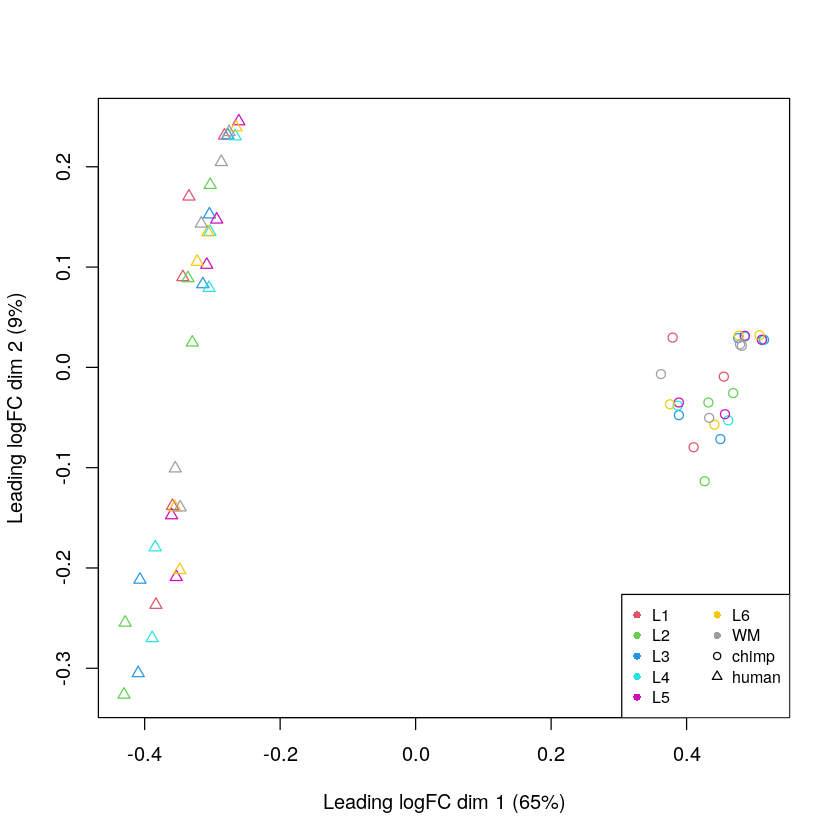

In [14]:
layer <- as.factor(y$samples$layer)
condition <- y$samples$condition
plotMDS(y, pch=c(1:3)[condition], col=c(2:8)[layer])
legend("bottomright", legend=c(levels(layer), levels(condition)), pch=c(rep(16, 7), c(1:5)), col=c(c(2:8), rep(1, 3)), cex=0.8, ncol=2)

### Design matrix

In [15]:
layer_c <- y$samples$layer_c
sample_id <- y$samples$sample_id
design <- model.matrix(~ sample_id + ns(layer_c, df=3) + condition:ns(layer_c, df=3))
colnames(design) <- gsub("condition", "", colnames(design))
colnames(design) <- gsub("sample_id", "", colnames(design))
colnames(design) <- gsub("ns\\(layer_c, df = 3)", "spline_", colnames(design))
head(design)

,(Intercept),chimp_13309,chimp_j11,chimp_j8,human_759,human_j12,human_j3,human_j4,human_j6,spline_1,spline_2,spline_3,spline_1:human,spline_2:human,spline_3:human
1,1,0,0,0,1,0,0,0,0,0.00000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000
2,1,0,0,0,0,1,0,0,0,0.00000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000
3,1,0,0,0,0,0,1,0,0,0.00000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000
4,1,0,0,0,0,0,0,1,0,0.00000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000
5,1,0,0,0,0,0,0,0,1,0.00000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000
6,1,0,0,0,1,0,0,0,0,-0.09686347,0.3530904,-0.2353936,-0.09686347,0.3530904,-0.2353936


In [16]:
colnames(design)

[1] "(Intercept)"    "chimp_13309"    "chimp_j11"      "chimp_j8"      
 [5] "human_759"      "human_j12"      "human_j3"       "human_j4"      
 [9] "human_j6"       "spline_1"       "spline_2"       "spline_3"      
[13] "spline_1:human" "spline_2:human" "spline_3:human"

### Dispersion estimation

In [17]:
y <- estimateDisp(y, design, robust=TRUE)
y$common.dispersion

[1] 9.765625e-05

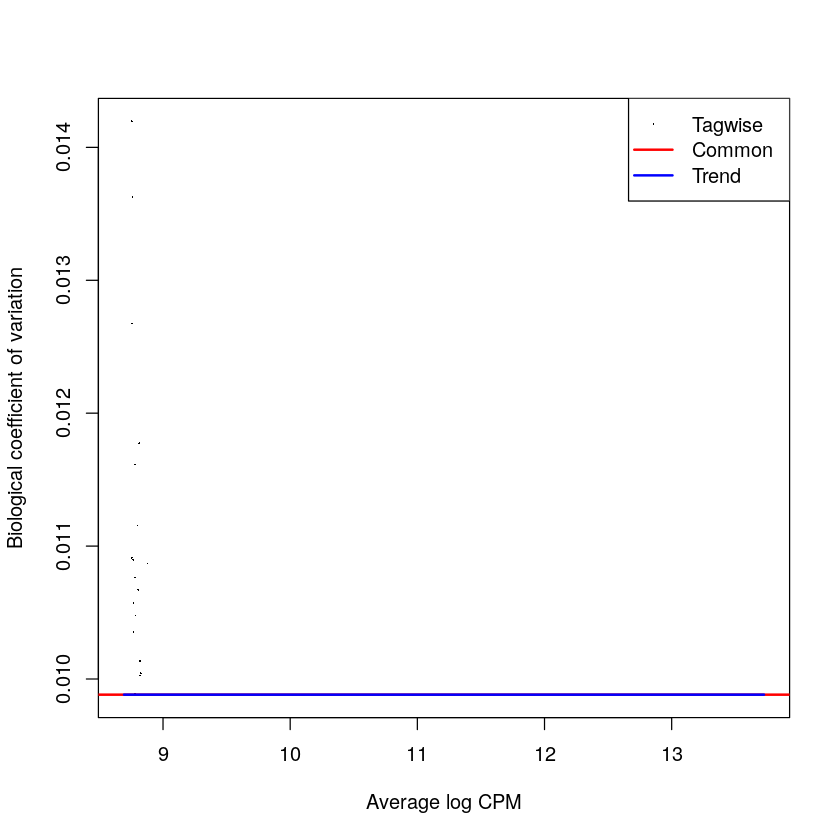

In [18]:
plotBCV(y)

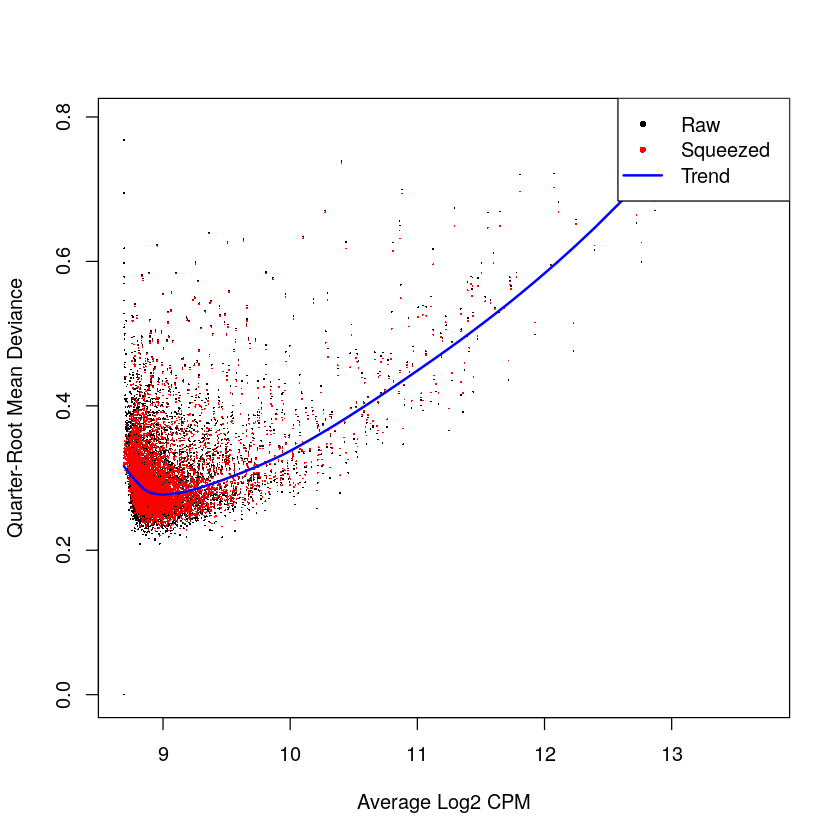

In [19]:
fit <- glmQLFit(y, design, robust=TRUE)
plotQLDisp(fit)

### DE genes identification

In [20]:
qlf <- glmQLFTest(fit, coef=13:15)

In [21]:
summary(decideTests(qlf))

       spline_3:human-spline_2:human-spline_1:human
NotSig                                         7540
Sig                                             261

In [22]:
write.csv(qlf$table, file='data/human_specific_genes/edgeR_human_chimp.csv')

## Human vs Macaque

### Prepare the data

Let's filter macaque samples in expression and annotation dataframes

In [23]:
comparison_ann <- annotation[(annotation$condition == 'human') | (annotation$condition == 'macaque'),]
head(comparison_ann)

,layer,sample_id,psbulk_cells,psbulk_counts,condition,lib_size,log_lib_size,layer_c
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>
human_759_L1,L1,human_759,500,1400502,human,2801.004,7.937733,1
human_j12_L1,L1,human_j12,331,1168612,human,3530.550,8.169209,1
human_j3_L1,L1,human_j3,110,536103,human,4873.664,8.491601,1
human_j4_L1,L1,human_j4,238,1038124,human,4361.866,8.380655,1
human_j6_L1,L1,human_j6,134,339404,human,2532.866,7.837107,1
human_759_L2,L2,human_759,406,1962071,human,4832.687,8.483158,2


In [24]:
comparison_expr <- expression[, row.names(comparison_ann)]
head(comparison_expr)

,human_759_L1,human_j12_L1,human_j3_L1,human_j4_L1,human_j6_L1,human_759_L2,human_j12_L2,human_j3_L2,human_j4_L2,human_j6_L2,⋯,macaque_0704_L5,macaque_nb0904_L5,macaque_0701_L6,macaque_0703_L6,macaque_0704_L6,macaque_nb0904_L6,macaque_0701_WM,macaque_0703_WM,macaque_0704_WM,macaque_nb0904_WM
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DUSP18,0.008,0.03927492,0.06363636,0.02100840,0.01492537,0.017241379,0.12571429,0.18367347,0.02564103,0.09174312,⋯,0.259259259,0.044571429,0.167883212,0.200381679,0.214983713,0.032951289,0.07407407,0.085714286,0.10389610,0.01136364
ANGPTL4,0.008,0.17522659,0.01818182,0.04201681,0.05223881,0.004926108,0.34857143,0.05102041,0.02991453,0.08256881,⋯,0.015250545,0.012571429,0.102189781,0.091603053,0.052117264,0.021489971,0.16049383,0.057142857,0.03896104,0.02272727
NUP133,0.088,0.09969789,0.32727273,0.18487395,0.05970149,0.169950739,0.34285714,0.82653061,0.45299145,0.24770642,⋯,0.394335512,0.118857143,0.200729927,0.286259542,0.257328990,0.101719198,0.12345679,0.190476190,0.15584416,0.03409091
FRY,0.220,0.32930514,0.54545455,0.60084034,0.21641791,0.662561576,1.70285714,2.68367347,1.96153846,0.81651376,⋯,0.002178649,0.004571429,0.007299270,0.005725191,0.003257329,0.005730659,0.00000000,0.004761905,0.01298701,0.00000000
FKBP7,0.010,0.01812689,0.04545455,0.02100840,0.02985075,0.034482759,0.02857143,0.23469388,0.05982906,0.11009174,⋯,0.084967320,0.052571429,0.047445255,0.055343511,0.071661238,0.041547278,0.04938272,0.071428571,0.09090909,0.04545455
SNAP29,0.072,0.11178248,0.15454545,0.11764706,0.05223881,0.140394089,0.25142857,0.54081633,0.26068376,0.11009174,⋯,0.010893246,0.005714286,0.003649635,0.015267176,0.000000000,0.007163324,0.00000000,0.009523810,0.00000000,0.00000000


Factor the data

In [25]:
comparison_ann$layer <- factor(comparison_ann$layer)
comparison_ann$sample_id <- factor(comparison_ann$sample_id)
comparison_ann$condition <- factor(comparison_ann$condition)
head(comparison_ann)

,layer,sample_id,psbulk_cells,psbulk_counts,condition,lib_size,log_lib_size,layer_c
,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<int>
human_759_L1,L1,human_759,500,1400502,human,2801.004,7.937733,1
human_j12_L1,L1,human_j12,331,1168612,human,3530.550,8.169209,1
human_j3_L1,L1,human_j3,110,536103,human,4873.664,8.491601,1
human_j4_L1,L1,human_j4,238,1038124,human,4361.866,8.380655,1
human_j6_L1,L1,human_j6,134,339404,human,2532.866,7.837107,1
human_759_L2,L2,human_759,406,1962071,human,4832.687,8.483158,2


In [26]:
y <- DGEList(counts=comparison_expr, samples=comparison_ann)


### Filtering and normalization

Let's check a summary table

In [27]:
summary(comparison_ann)

 layer         sample_id   psbulk_cells    psbulk_counts        condition 
 L1:9   human_759   : 7   Min.   :  77.0   Min.   :  103562   human  :35  
 L2:9   human_j12   : 7   1st Qu.: 236.5   1st Qu.: 1164706   macaque:28  
 L3:9   human_j3    : 7   Median : 351.0   Median : 2339807               
 L4:9   human_j4    : 7   Mean   : 459.6   Mean   : 2918649               
 L5:9   human_j6    : 7   3rd Qu.: 573.5   3rd Qu.: 3515457               
 L6:9   macaque_0701: 7   Max.   :1465.0   Max.   :11767665               
 WM:9   (Other)     :21                                                   
    lib_size      log_lib_size      layer_c 
 Min.   : 1177   Min.   :7.071   Min.   :1  
 1st Qu.: 2847   1st Qu.:7.954   1st Qu.:2  
 Median : 5312   Median :8.578   Median :4  
 Mean   : 6937   Mean   :8.595   Mean   :4  
 3rd Qu.: 9580   3rd Qu.:9.167   3rd Qu.:6  
 Max.   :20796   Max.   :9.943   Max.   :7  
                                            

In [28]:
y <- y[keep.genes, , keep=FALSE]

In [29]:
y <- normLibSizes(y)
head(y$samples, n=10L)

,group,lib.size,norm.factors,layer,sample_id,psbulk_cells,psbulk_counts,condition,lib_size,log_lib_size,layer_c
,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<int>
human_759_L1,1,1827.188,0.9264771,L1,human_759,500,1400502,human,2801.004,7.937733,1
human_j12_L1,1,2384.432,0.9323888,L1,human_j12,331,1168612,human,3530.550,8.169209,1
human_j3_L1,1,3264.727,0.9872370,L1,human_j3,110,536103,human,4873.664,8.491601,1
human_j4_L1,1,3111.050,0.9238448,L1,human_j4,238,1038124,human,4361.866,8.380655,1
human_j6_L1,1,1789.321,0.9682521,L1,human_j6,134,339404,human,2532.866,7.837107,1
human_759_L2,1,3448.606,0.9628353,L2,human_759,406,1962071,human,4832.687,8.483158,2
human_j12_L2,1,8466.080,0.9685339,L2,human_j12,175,2049899,human,11713.709,9.368515,2
human_j3_L2,1,13806.653,0.9391543,L2,human_j3,98,1861527,human,18995.173,9.851940,2
human_j4_L2,1,7613.795,0.9566104,L2,human_j4,234,2390952,human,10217.744,9.231881,2


In [30]:
summary(y$samples$norm.factors)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9238  0.9672  0.9872  1.0013  1.0254  1.1638 

### Data exploration

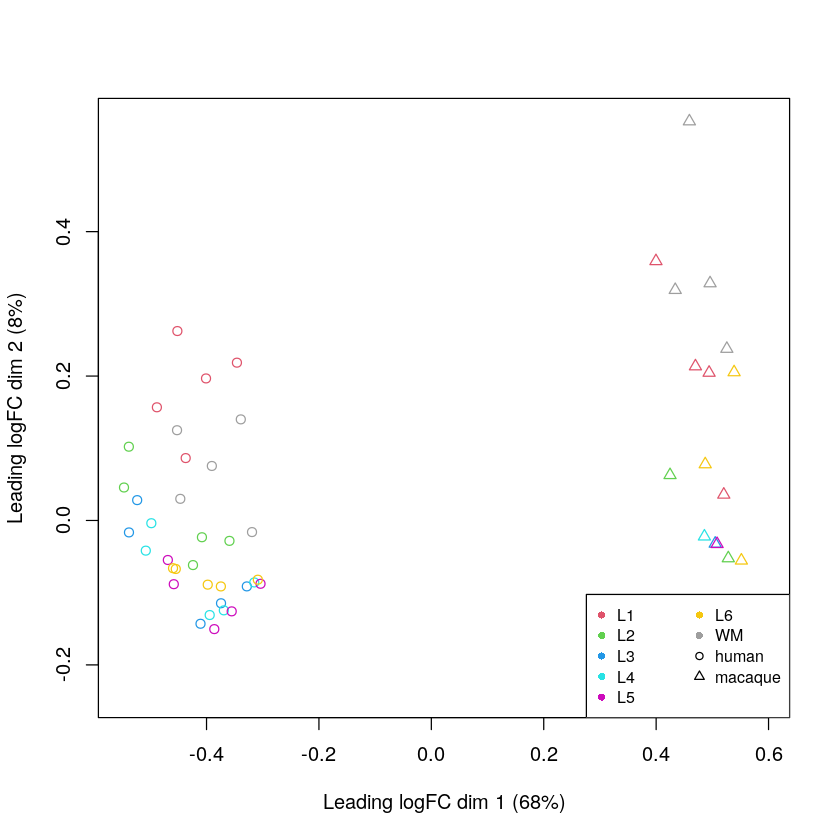

In [31]:
layer <- as.factor(y$samples$layer)
condition <- y$samples$condition
plotMDS(y, pch=c(1:3)[condition], col=c(2:8)[layer])
legend("bottomright", legend=c(levels(layer), levels(condition)), pch=c(rep(16, 7), c(1:5)), col=c(c(2:8), rep(1, 3)), cex=0.8, ncol=2)

### Design matrix

In [32]:
layer_c <- y$samples$layer_c
sample_id <- y$samples$sample_id
design <- model.matrix(~ sample_id + ns(layer_c, df=3) + condition:ns(layer_c, df=3))
colnames(design) <- gsub("condition", "", colnames(design))
colnames(design) <- gsub("sample_id", "", colnames(design))
colnames(design) <- gsub("ns\\(layer_c, df = 3)", "spline_", colnames(design))
head(design)

,(Intercept),human_j12,human_j3,human_j4,human_j6,macaque_0701,macaque_0703,macaque_0704,macaque_nb0904,spline_1,spline_2,spline_3,spline_1:macaque,spline_2:macaque,spline_3:macaque
1,1,0,0,0,0,0,0,0,0,0.00000000,0.0000000,0.0000000,0,0,0
2,1,1,0,0,0,0,0,0,0,0.00000000,0.0000000,0.0000000,0,0,0
3,1,0,1,0,0,0,0,0,0,0.00000000,0.0000000,0.0000000,0,0,0
4,1,0,0,1,0,0,0,0,0,0.00000000,0.0000000,0.0000000,0,0,0
5,1,0,0,0,1,0,0,0,0,0.00000000,0.0000000,0.0000000,0,0,0
6,1,0,0,0,0,0,0,0,0,-0.09686347,0.3530904,-0.2353936,0,0,0


In [33]:
colnames(design)

[1] "(Intercept)"      "human_j12"        "human_j3"         "human_j4"        
 [5] "human_j6"         "macaque_0701"     "macaque_0703"     "macaque_0704"    
 [9] "macaque_nb0904"   "spline_1"         "spline_2"         "spline_3"        
[13] "spline_1:macaque" "spline_2:macaque" "spline_3:macaque"

### Dispersion estimation

In [34]:
y <- estimateDisp(y, design, robust=TRUE)
y$common.dispersion

[1] 9.765625e-05

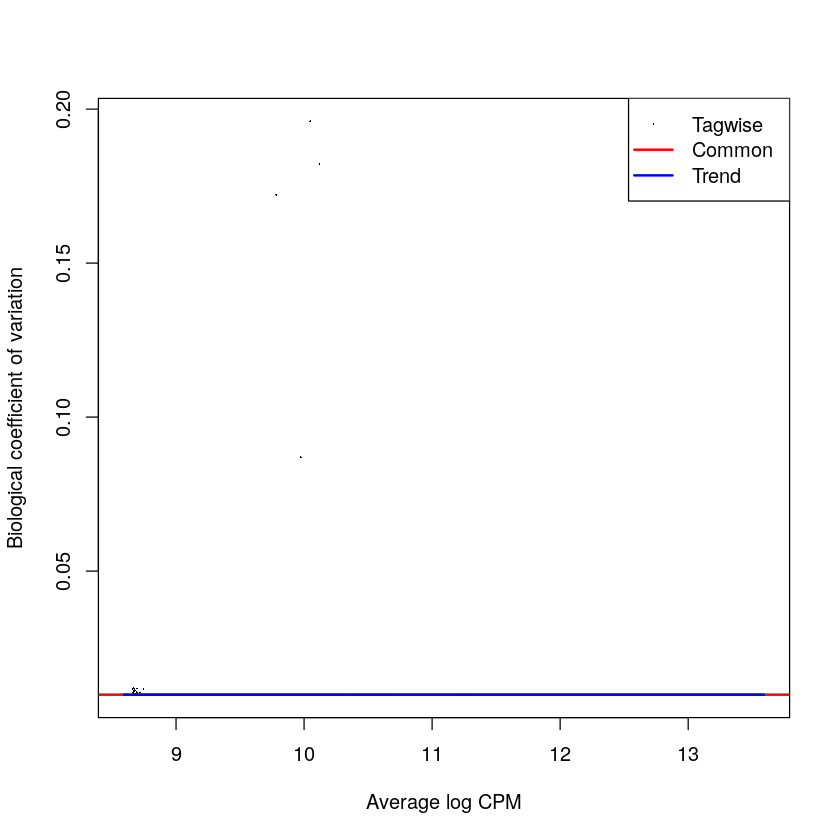

In [35]:
plotBCV(y)

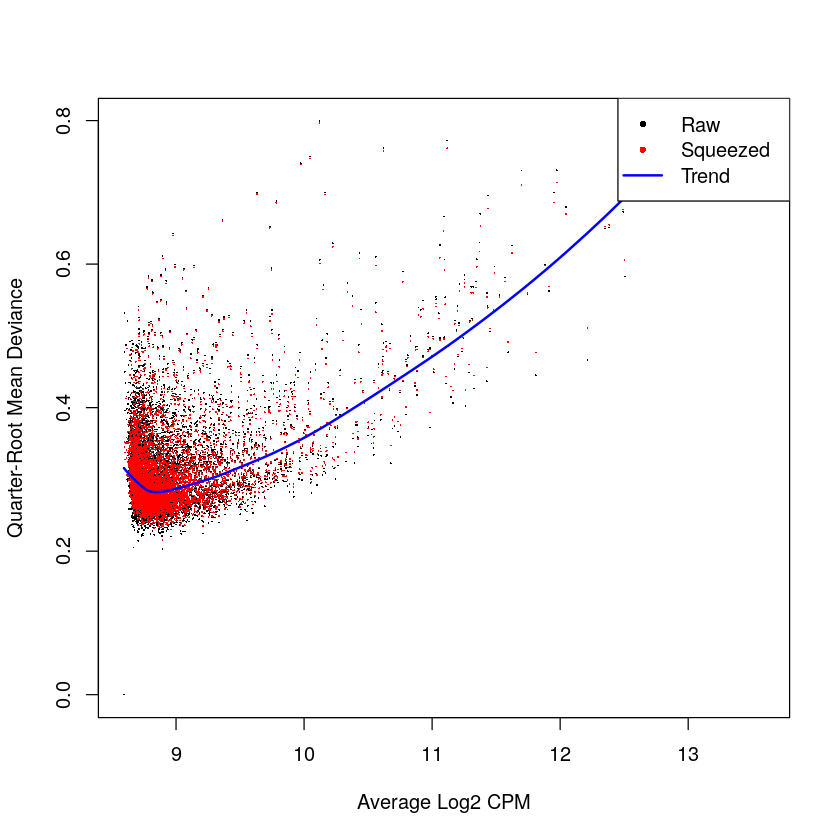

In [36]:
fit <- glmQLFit(y, design, robust=TRUE)
plotQLDisp(fit)

### DE genes identification

In [37]:
qlf <- glmQLFTest(fit, coef=13:15)

In [38]:
summary(decideTests(qlf))

       spline_3:macaque-spline_2:macaque-spline_1:macaque
NotSig                                               5949
Sig                                                  1852

In [39]:
write.csv(qlf$table, file='data/human_specific_genes/edgeR_human_macaque.csv')

## Chimp vs Macaque

### Prepare the data

Let's filter macaque samples in expression and annotation dataframes

In [40]:
comparison_ann <- annotation[(annotation$condition == 'macaque') | (annotation$condition == 'chimp'),]
head(comparison_ann)

,layer,sample_id,psbulk_cells,psbulk_counts,condition,lib_size,log_lib_size,layer_c
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>
chimp_11454_L1,L1,chimp_11454,202,550717,chimp,2726.322,7.910709,1
chimp_13309_L1,L1,chimp_13309,201,440678,chimp,2192.428,7.692765,1
chimp_j8_L1,L1,chimp_j8,398,1140103,chimp,2864.580,7.960177,1
chimp_11454_L2,L2,chimp_11454,167,688654,chimp,4123.677,8.324500,2
chimp_13309_L2,L2,chimp_13309,136,575274,chimp,4229.956,8.349947,2
chimp_j8_L2,L2,chimp_j8,201,1542094,chimp,7672.109,8.945347,2


In [41]:
comparison_expr <- expression[, row.names(comparison_ann)]
head(comparison_expr)

,chimp_11454_L1,chimp_13309_L1,chimp_j8_L1,chimp_11454_L2,chimp_13309_L2,chimp_j8_L2,chimp_11454_L3,chimp_13309_L3,chimp_j11_L3,chimp_j8_L3,⋯,macaque_0704_L5,macaque_nb0904_L5,macaque_0701_L6,macaque_0703_L6,macaque_0704_L6,macaque_nb0904_L6,macaque_0701_WM,macaque_0703_WM,macaque_0704_WM,macaque_nb0904_WM
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DUSP18,0.004950495,0.009950249,0.01256281,0.017964072,0.007352941,0.009950249,0.02457002,0.05871886,0.054644809,0.04959786,⋯,0.259259259,0.044571429,0.167883212,0.200381679,0.214983713,0.032951289,0.07407407,0.085714286,0.10389610,0.01136364
ANGPTL4,0.019801980,0.004975124,0.03266332,0.005988024,0.007352941,0.029850746,0.01474201,0.01779359,0.005464481,0.02815013,⋯,0.015250545,0.012571429,0.102189781,0.091603053,0.052117264,0.021489971,0.16049383,0.057142857,0.03896104,0.02272727
NUP133,0.118811881,0.109452736,0.15577889,0.257485030,0.161764706,0.442786070,0.19164619,0.37277580,0.185792350,0.49061662,⋯,0.394335512,0.118857143,0.200729927,0.286259542,0.257328990,0.101719198,0.12345679,0.190476190,0.15584416,0.03409091
FRY,0.237623762,0.338308458,0.47236181,0.556886228,0.808823529,1.850746269,0.54299754,1.37099644,0.726775956,2.08310992,⋯,0.002178649,0.004571429,0.007299270,0.005725191,0.003257329,0.005730659,0.00000000,0.004761905,0.01298701,0.00000000
FKBP7,0.054455446,0.009950249,0.01758794,0.035928144,0.007352941,0.029850746,0.01719902,0.02758007,0.010928962,0.02278820,⋯,0.084967320,0.052571429,0.047445255,0.055343511,0.071661238,0.041547278,0.04938272,0.071428571,0.09090909,0.04545455
SNAP29,0.069306931,0.064676617,0.11809045,0.191616766,0.110294118,0.273631841,0.16830467,0.29626335,0.224043716,0.36595174,⋯,0.010893246,0.005714286,0.003649635,0.015267176,0.000000000,0.007163324,0.00000000,0.009523810,0.00000000,0.00000000


Factor the data

In [42]:
comparison_ann$layer <- factor(comparison_ann$layer)
comparison_ann$sample_id <- factor(comparison_ann$sample_id)
comparison_ann$condition <- factor(comparison_ann$condition)
head(comparison_ann)

,layer,sample_id,psbulk_cells,psbulk_counts,condition,lib_size,log_lib_size,layer_c
,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<int>
chimp_11454_L1,L1,chimp_11454,202,550717,chimp,2726.322,7.910709,1
chimp_13309_L1,L1,chimp_13309,201,440678,chimp,2192.428,7.692765,1
chimp_j8_L1,L1,chimp_j8,398,1140103,chimp,2864.580,7.960177,1
chimp_11454_L2,L2,chimp_11454,167,688654,chimp,4123.677,8.324500,2
chimp_13309_L2,L2,chimp_13309,136,575274,chimp,4229.956,8.349947,2
chimp_j8_L2,L2,chimp_j8,201,1542094,chimp,7672.109,8.945347,2


In [43]:
y <- DGEList(counts=comparison_expr, samples=comparison_ann)


### Filtering and normalization

Let's check a summary table

In [44]:
summary(comparison_ann)

 layer         sample_id   psbulk_cells    psbulk_counts        condition 
 L1:7   chimp_11454 : 7   Min.   :  77.0   Min.   :  103562   chimp  :26  
 L2:7   chimp_13309 : 7   1st Qu.: 236.0   1st Qu.:  935654   macaque:28  
 L3:8   chimp_j8    : 7   Median : 398.0   Median : 1914698               
 L4:8   macaque_0701: 7   Mean   : 536.8   Mean   : 2667652               
 L5:8   macaque_0703: 7   3rd Qu.: 710.0   3rd Qu.: 3243140               
 L6:8   macaque_0704: 7   Max.   :2309.0   Max.   :11767665               
 WM:8   (Other)     :12                                                   
    lib_size      log_lib_size      layer_c     
 Min.   : 1177   Min.   :7.071   Min.   :1.000  
 1st Qu.: 2554   1st Qu.:7.845   1st Qu.:2.250  
 Median : 4451   Median :8.401   Median :4.000  
 Mean   : 5093   Mean   :8.358   Mean   :4.093  
 3rd Qu.: 7287   3rd Qu.:8.894   3rd Qu.:6.000  
 Max.   :12431   Max.   :9.428   Max.   :7.000  
                                                

In [45]:
y <- y[keep.genes, , keep=FALSE]

In [46]:
y <- normLibSizes(y)
head(y$samples, n=10L)

,group,lib.size,norm.factors,layer,sample_id,psbulk_cells,psbulk_counts,condition,lib_size,log_lib_size,layer_c
,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<int>
chimp_11454_L1,1,1697.094,1.0067640,L1,chimp_11454,202,550717,chimp,2726.322,7.910709,1
chimp_13309_L1,1,1495.532,1.0540621,L1,chimp_13309,201,440678,chimp,2192.428,7.692765,1
chimp_j8_L1,1,2075.884,1.0216298,L1,chimp_j8,398,1140103,chimp,2864.580,7.960177,1
chimp_11454_L2,1,2911.766,1.0120555,L2,chimp_11454,167,688654,chimp,4123.677,8.324500,2
chimp_13309_L2,1,2930.743,1.0502023,L2,chimp_13309,136,575274,chimp,4229.956,8.349947,2
chimp_j8_L2,1,5866.318,0.9864605,L2,chimp_j8,201,1542094,chimp,7672.109,8.945347,2
chimp_11454_L3,1,3084.932,0.9580757,L3,chimp_11454,814,3556521,chimp,4369.190,8.382333,3
chimp_13309_L3,1,5532.667,0.9589286,L3,chimp_13309,1124,8816414,chimp,7843.785,8.967477,3
chimp_j11_L3,1,4366.120,0.8969673,L3,chimp_j11,183,1147695,chimp,6271.557,8.743780,3


In [47]:
summary(y$samples$norm.factors)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8955  0.9661  1.0102  1.0010  1.0368  1.0657 

### Data exploration

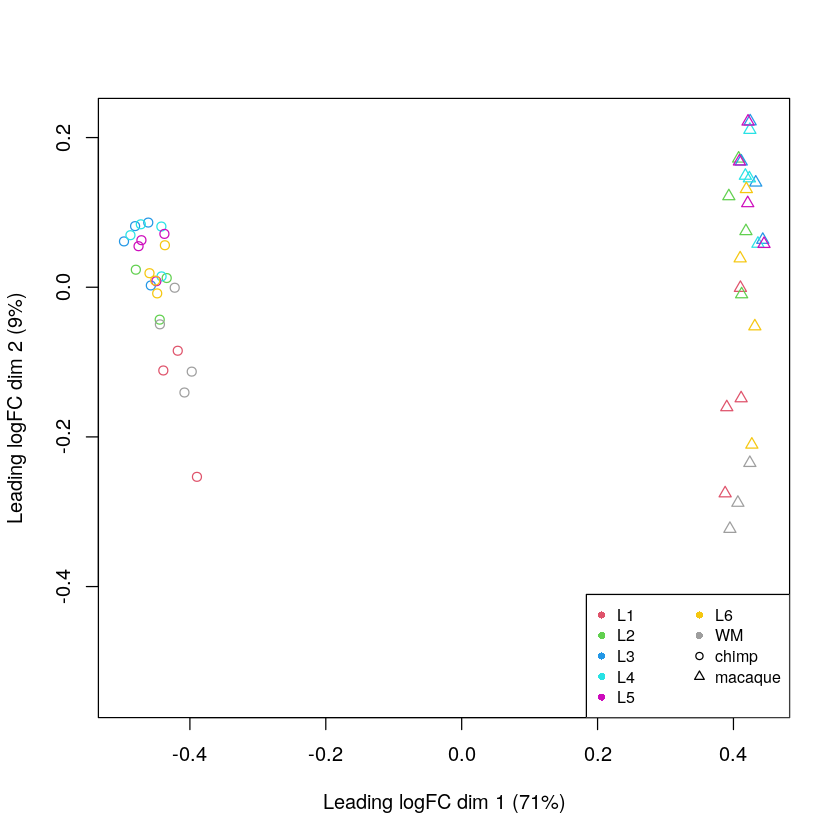

In [48]:
layer <- as.factor(y$samples$layer)
condition <- y$samples$condition
plotMDS(y, pch=c(1:3)[condition], col=c(2:8)[layer])
legend("bottomright", legend=c(levels(layer), levels(condition)), pch=c(rep(16, 7), c(1:5)), col=c(c(2:8), rep(1, 3)), cex=0.8, ncol=2)

### Design matrix

In [49]:
layer_c <- y$samples$layer_c
sample_id <- y$samples$sample_id
design <- model.matrix(~ sample_id + ns(layer_c, df=3) + condition:ns(layer_c, df=3))
colnames(design) <- gsub("condition", "", colnames(design))
colnames(design) <- gsub("sample_id", "", colnames(design))
colnames(design) <- gsub("ns\\(layer_c, df = 3)", "spline_", colnames(design))
head(design)

,(Intercept),chimp_13309,chimp_j11,chimp_j8,macaque_0701,macaque_0703,macaque_0704,macaque_nb0904,spline_1,spline_2,spline_3,spline_1:macaque,spline_2:macaque,spline_3:macaque
1,1,0,0,0,0,0,0,0,0.00000000,0.0000000,0.0000000,0,0,0
2,1,1,0,0,0,0,0,0,0.00000000,0.0000000,0.0000000,0,0,0
3,1,0,0,1,0,0,0,0,0.00000000,0.0000000,0.0000000,0,0,0
4,1,0,0,0,0,0,0,0,-0.09686347,0.3530904,-0.2353936,0,0,0
5,1,1,0,0,0,0,0,0,-0.09686347,0.3530904,-0.2353936,0,0,0
6,1,0,0,1,0,0,0,0,-0.09686347,0.3530904,-0.2353936,0,0,0


In [50]:
colnames(design)

[1] "(Intercept)"      "chimp_13309"      "chimp_j11"        "chimp_j8"        
 [5] "macaque_0701"     "macaque_0703"     "macaque_0704"     "macaque_nb0904"  
 [9] "spline_1"         "spline_2"         "spline_3"         "spline_1:macaque"
[13] "spline_2:macaque" "spline_3:macaque"

### Dispersion estimation

In [51]:
y <- estimateDisp(y, design, robust=TRUE)
y$common.dispersion

[1] 9.765625e-05

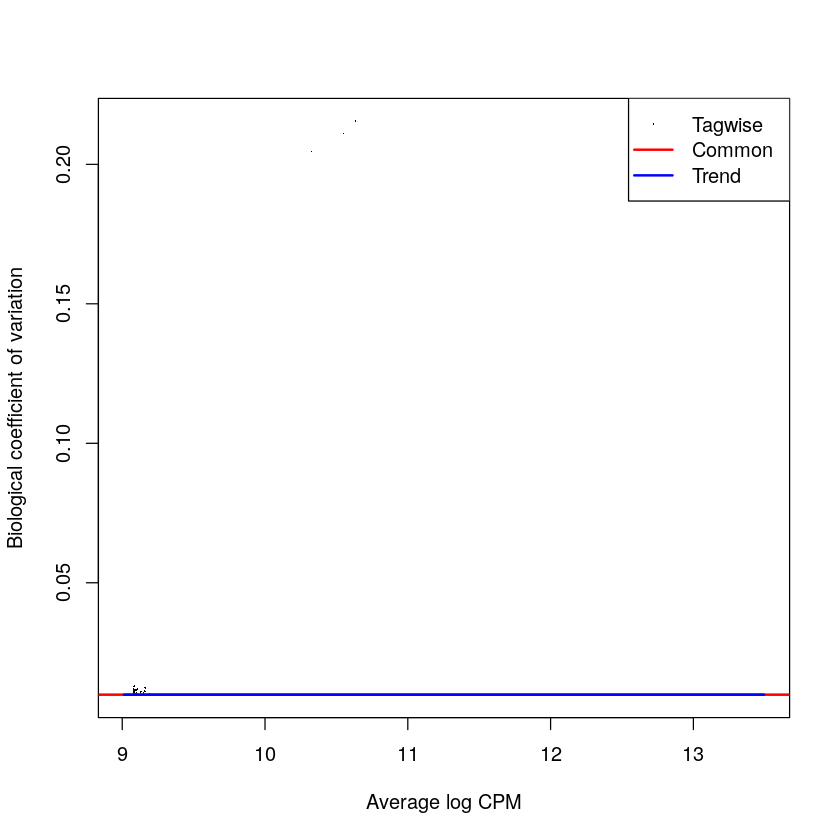

In [52]:
plotBCV(y)

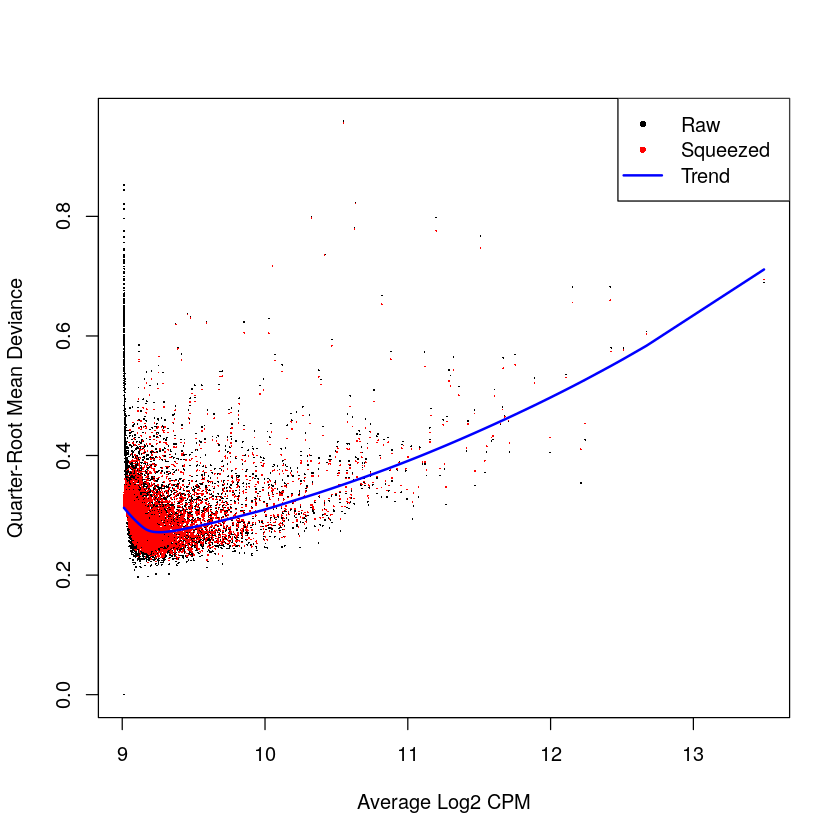

In [53]:
fit <- glmQLFit(y, design, robust=TRUE)
plotQLDisp(fit)

### DE genes identification

In [54]:
qlf <- glmQLFTest(fit, coef=12:14)

In [55]:
summary(decideTests(qlf))

       spline_3:macaque-spline_2:macaque-spline_1:macaque
NotSig                                               6880
Sig                                                   921

In [56]:
write.csv(qlf$table, file='data/human_specific_genes/edgeR_chimp_macaque.csv')